# Introduction

Following the order of cells in this notebook, you can finish the training processing easily.

Considering this task is relativily easy, we only use single model and can achieve a very high accuracy (micro F1) of 97%. To keep the prediction process efficiently, we do not perform model ensemble.

## 1 Setup environments

### 1.1. Import Python dependencies and Setup GPU.

Here, we use GPU 0 in default. If you have multiple GPUs, please specific the <ID\> of GPU you want to use for training as following:

```python
os.environ["CUDA_VISIBLE_DEVICES"] = "<ID>"
```

In [1]:
# import common used libs
import os
import glob
import random
import copy

# use single GPU, please specify the GPU ID if have multiple GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# cv libs
import cv2
import numpy as np

# deep learning libs
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from efficientnet_pytorch import model as enet

import albumentations as A
from albumentations.pytorch import ToTensorV2

from catalyst import dl, metrics, utils

# for better visualization
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

### 1.2. Setup paths and hyperparameters.

In this cell, we setup the training and validation data paths, which is orgnized as same as ImageNet dataset.
We define the architecture of model and training hyperparameters here.

Note: set the DEBUG conifg to True will reduce the number of training epoches and the image base size. 
This is only used for demo.

In [2]:
# 7 shoes class name
CLASSES = ["sneakers", "boots", "loafers", "sandals", "flip_flops", "soccer_shoes", "no_shoe_found"]

# training and validation data root
TRAIN_ROOT = "./data/train"
VAL_ROOT = './data/val'

# resize image longest side to <BASE_SIZE>
BASE_SIZE = 640

# hyperparameters for dataloader
# reduce <BATCH_SIZE> and <NUM_WORKERS> if GPU memory or CPU is not enough. This will influence model performance.
BATCH_SIZE = 16
NUM_WORKERS = 16 # number of processes 

# Model backbone and pretrained weights
BACKBONE = 'efficientnet-b6'
PRETRAINED_MODEL_PATH = './efficientnet-b6-c76e70fd.pth'

# training hyperparameters
NUM_EPOCH = 80
MAX_LR = 1e-4

# output log dir
LOG_DIR = "./logs"

# final model path
FINAL_MODEL_PATH = "./checkpoints/final.pth"

# for debug. Training less epoches for smaller images
DEBUG = False
if DEBUG:
    BASE_SIZE = 256
    NUM_EPOCH = 3
    FINAL_MODEL_PATH = './checkpoints/debug.pth'

### 1.3. Setup random seed.

In this cell, we set the seed of the entire notebook so results are the same every time we run. This is for reproducibility.

In [3]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

## 2. Prepare Data

### 2.1 prepare training and validation list

In this cell, we construct the training and validation list from TRAIN_ROOT and VAL_ROOT.
There are 2800 images for training and 1050 images for validation.

In [4]:
"""prepare training and validation sample list"""
train_samples = []
val_samples = []
for class_idx, class_name in enumerate(CLASSES):
    # generate training sample list
    train_dir = os.path.join(TRAIN_ROOT, class_name)
    for file_path in glob.glob(os.path.join(train_dir, '*.jpg')):
        train_samples.append((file_path, class_idx))
        
    # generate validation sample list
    val_dir = os.path.join(VAL_ROOT, class_name)
    for file_path in glob.glob(os.path.join(val_dir, '*.jpg')):
        val_samples.append((file_path, class_idx))

print(f"#train = {len(train_samples)}, #val = {len(val_samples)}")

#train = 2800, #val = 1050


### 2.2 visualize training datas

In this cell, we visualize the training samples. We random samples 25 images from training set and visualize them together with their labels. 

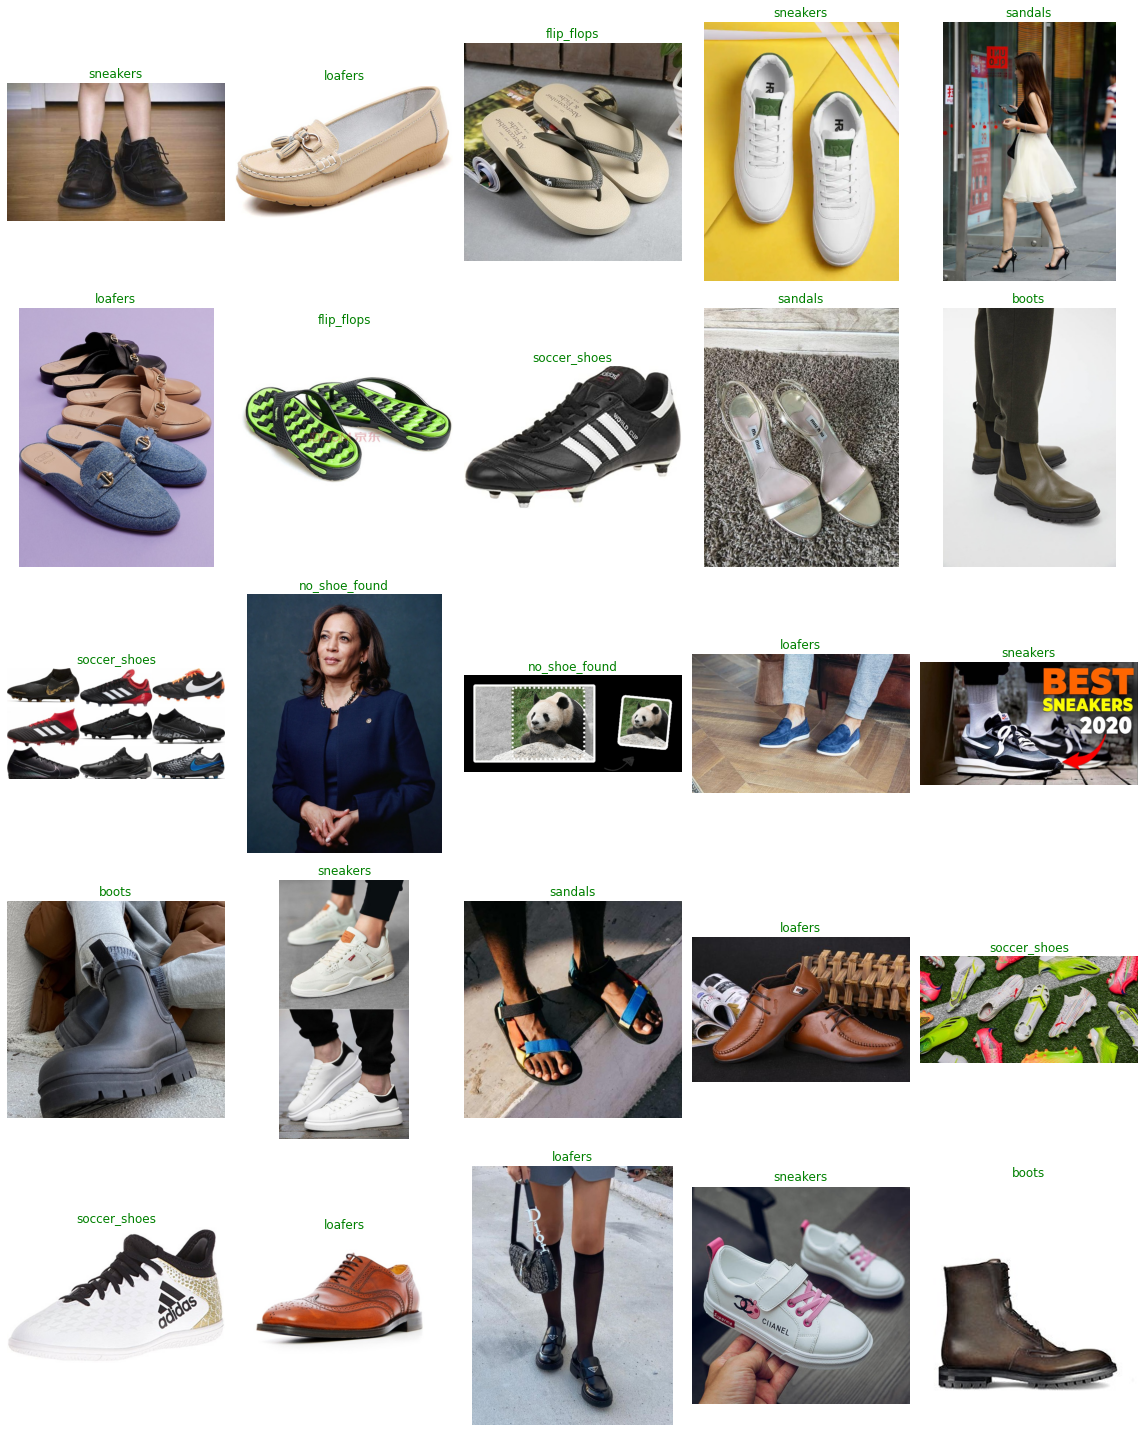

In [5]:
""" data visualization"""
def display_image_grid(image_samples, predicted_labels=(), classes=None, cols=5):
    """ref: https://albumentations.ai/docs/examples/pytorch_classification/"""
    rows = (len(image_samples) - 1) // cols + 1
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 20))
    for i, (image_filepath, true_label) in enumerate(image_samples):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        if classes is not None:
            predicted_label = classes[predicted_label]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visual_samples = [train_samples[i] for i in np.random.choice(len(train_samples), 25, replace=False)]
display_image_grid(visual_samples, classes=CLASSES)

### 2.3 setup dataset and dataloader

In this cell, we first setup datasets with strong data augmentation.
Data augmentation is implemented by Albumentation (https://github.com/albumentations-team/albumentations/ ) library, which is common used in computer vision tasks. Since the number of training samples in this task is very small, we perform strong data augmentation including different types of random transform, color jitter and blur.

Then we setup the dataloader with multiprocessing.

In [6]:
""" dataset and dataloader """ 
class ShoesDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_filepath, label = self.samples[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        sample = {
            'image': image, 
            'target': label,
        }
        return sample

# training data augmentation
train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=BASE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.PadIfNeeded(p=1.0, min_height=BASE_SIZE, min_width=BASE_SIZE),
        A.RandomCrop(height=BASE_SIZE, width=BASE_SIZE),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.OneOf([
            A.MotionBlur(p=1),
            A.OpticalDistortion(p=1),
            A.GaussNoise(p=1)                 
        ], p=0.75),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = ShoesDataset(train_samples, transform=train_transform)

# evaluation data augmentation
val_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=BASE_SIZE),
        A.PadIfNeeded(p=1.0, min_height=BASE_SIZE, min_width=BASE_SIZE),
        A.CenterCrop(height=BASE_SIZE, width=BASE_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = ShoesDataset(val_samples, transform=val_transform)

# data loaders
loaders = {
    "train": DataLoader(
        train_dataset, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, 
        shuffle=True, drop_last=False
    ),
    "valid": DataLoader(
        val_dataset, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, 
        shuffle=False, drop_last=False
    ),
}

### 2.4 visualize data augmentation

In this cell, we visualize the data augmentation for training. We sample 3 images and perform 10 times random data augmentation.

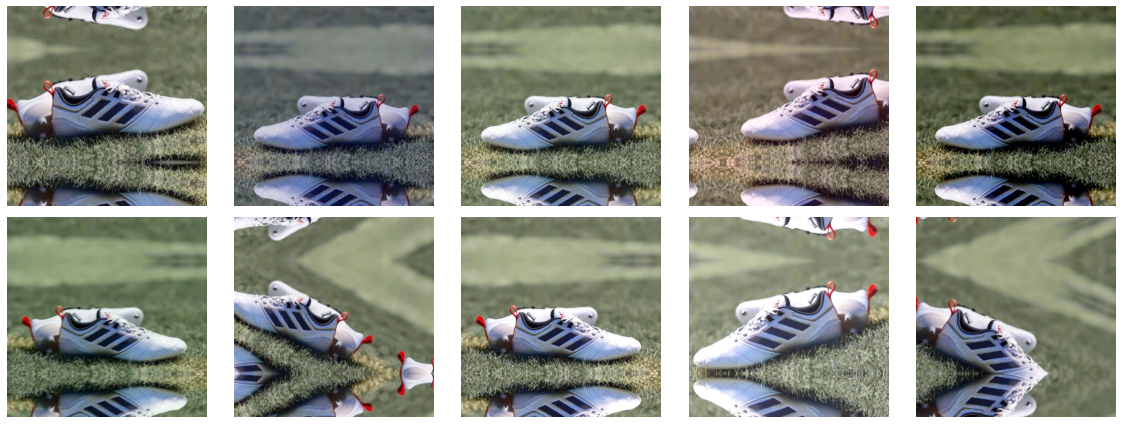

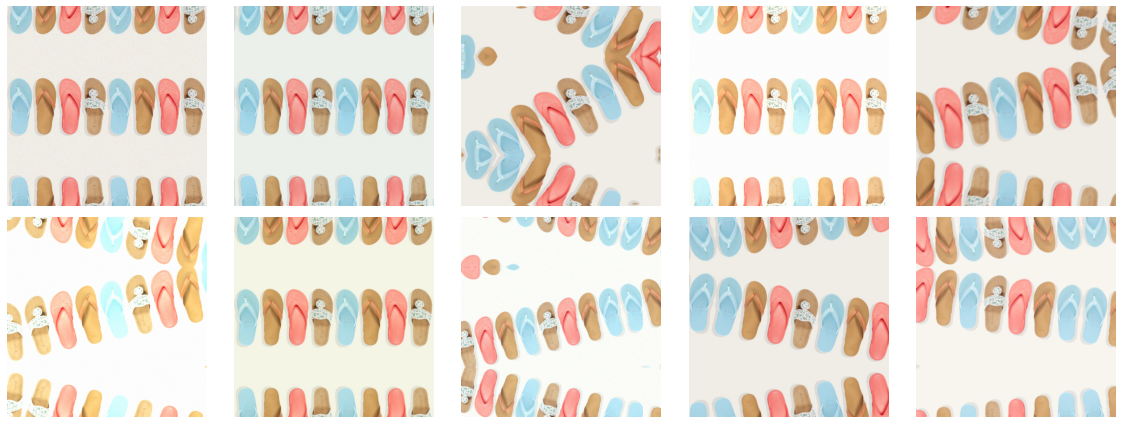

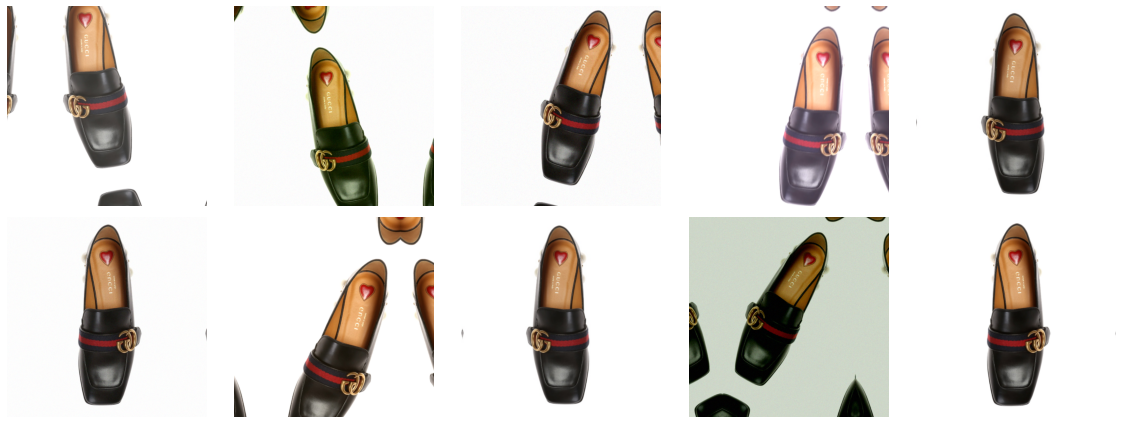

In [7]:
"""training augmentation visualization"""
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 6))
    for i in range(samples):
        image = dataset[idx]['image']
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()   
    
for idx in np.random.choice(len(train_dataset), 3):
    visualize_augmentations(train_dataset, idx=idx)

## 3. Training

### 3.1 Define the Model

In this cell, we define the model architecture.
We use EfficientNet (https://arxiv.org/abs/1905.11946) as our backbone model and add a Swish activation (https://arxiv.org/abs/1710.05941v1) with an additional Linear layer to perform classification.

In [8]:
"""
ref: https://www.kaggle.com/reighns/custom-head-gradual-warmup-single-fold-0-97
"""
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_Module(torch.nn.Module):
    def forward(self, x):
        return Swish.apply(x)
    
class ClsModel(nn.Module):
    def __init__(self, backbone, pretrained_model_path, out_dim):
        super(ClsModel, self).__init__()
        self.enet = enet.EfficientNet.from_name(BACKBONE)
        self.enet.load_state_dict(torch.load(pretrained_model_path))
        
        in_features = self.enet._fc.in_features
        self.enet._fc = nn.Identity()
        self.activation = Swish_Module()
        self.head = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
            self.activation,
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features, out_dim),
        )
        
    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.head(x)
        return x

### 3.2 Define the Evaluation metric

In this cell, we define the evaluation metric, we use the Micro F1 score during training and validation.

In [9]:
""" Keep only micro F1 metrics. """
class CustomF1Metric(metrics.MulticlassPrecisionRecallF1SupportMetric):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def compute_key_value(self):
        kv_metrics = super().compute_key_value()
        keep_metrics = {'F1/micro': kv_metrics['f1/_micro']}
        return keep_metrics

""" Custom Metric callback for better console log."""
class CustomF1Callback(dl.BatchMetricCallback):
    def __init__(self, input_key, target_key, num_classes, log_on_batch):
        super().__init__(
            metric=CustomF1Metric(
                num_classes=num_classes, zero_division=0, prefix=None, suffix=None
            ),
            input_key=input_key,
            target_key=target_key,
            log_on_batch=log_on_batch,
        )

### 3.3 Trainining

In this cell, we use Catalyst (https://github.com/catalyst-team/catalyst/) to start training processing. It takes about 3 minutes to training 1 epoch in single V100 GPU.
The whole training process takes around 4 hours.

If your GPU do not have 32GB Memory, please reduce the BATCH_SIZE hyperparameter to fit your GPU Memory. But this may result in worse performance.

In [10]:
""" model training """ 
model = ClsModel(BACKBONE, PRETRAINED_MODEL_PATH, out_dim=len(CLASSES))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, epochs=NUM_EPOCH, steps_per_epoch=len(loaders['train']),
    max_lr=MAX_LR, pct_start=0.1, 
    div_factor=1e3, final_div_factor=1e3
)

# start train loop
runner = dl.SupervisedRunner(input_key="image", output_key="logits", target_key="target", loss_key="loss")
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=NUM_EPOCH,
    logdir=LOG_DIR,
    verbose=True,
    valid_metric="F1/micro", 
    minimize_valid_metric=False,
    callbacks=[
        CustomF1Callback(
            input_key="logits", target_key="target", num_classes=7, log_on_batch=False
        ),
        dl.SchedulerCallback(mode='batch'),
        dl.CheckpointCallback(
            '%s/checkpoints'%LOG_DIR, loader_key="valid", metric_key="F1/micro", minimize=False, save_n_best=1
        ),
    ],
    amp=True,
)

1/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

<ipython-input-8-5991cf752121>:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]
/workspace/envs/env-py3-shoe/miniconda3/lib/python3.8/site-packages/catalyst/core/runner.py:716: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k: runner.engine.sync_tensor(torch.tensor(v, device=runner.device), "mean")


train (1/80) F1/micro: 0.14999500016666112 | loss: 1.944562315940857 | loss/mean: 1.944562315940857 | loss/std: 0.012801779605596926 | lr: 3.907584757066636e-06 | momentum: 0.9461886038467802


1/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (1/80) F1/micro: 0.2514235715280013 | loss: 1.931591272354126 | loss/mean: 1.931591272354126 | loss/std: 0.010764243191219932 | lr: 3.907584757066636e-06 | momentum: 0.9461886038467802
* Epoch (1/80) 


2/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (2/80) F1/micro: 0.3542807143562779 | loss: 1.892190933227539 | loss/mean: 1.892190933227539 | loss/std: 0.04272976237867299 | lr: 1.4749850472420818e-05 | momentum: 0.9353354850125918


2/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (2/80) F1/micro: 0.6904711905123971 | loss: 1.7432496547698975 | loss/mean: 1.7432496547698975 | loss/std: 0.1253248225117071 | lr: 1.4749850472420818e-05 | momentum: 0.9353354850125918
* Epoch (2/80) 


3/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (3/80) F1/micro: 0.588923571471021 | loss: 1.4747178554534912 | loss/mean: 1.4747178554534912 | loss/std: 0.25476495385526343 | lr: 3.097383035247503e-05 | momentum: 0.9190952649124373


3/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (3/80) F1/micro: 0.8180902381257967 | loss: 0.8642591238021851 | loss/mean: 0.8642591238021851 | loss/std: 0.4100564777600579 | lr: 3.097383035247503e-05 | momentum: 0.9190952649124373
* Epoch (3/80) 


4/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (4/80) F1/micro: 0.7635664286041692 | loss: 0.7505247592926025 | loss/mean: 0.7505247592926025 | loss/std: 0.21984896261365436 | lr: 5.0106083817039075e-05 | momentum: 0.8999438600430039


4/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (4/80) F1/micro: 0.8780902381237086 | loss: 0.3663989305496216 | loss/mean: 0.3663989305496216 | loss/std: 0.23433912814742658 | lr: 5.0106083817039075e-05 | momentum: 0.8999438600430039
* Epoch (4/80) 


5/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (5/80) F1/micro: 0.8553521428863701 | loss: 0.4329126477241516 | loss/mean: 0.4329126477241516 | loss/std: 0.18571230777291067 | lr: 6.92297869758223e-05 | momentum: 0.8808010140382159


5/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (5/80) F1/micro: 0.9190426190748209 | loss: 0.22475963830947876 | loss/mean: 0.22475963830947876 | loss/std: 0.1788573017263025 | lr: 6.92297869758223e-05 | momentum: 0.8808010140382159
* Epoch (5/80) 


6/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (6/80) F1/micro: 0.9096378571703404 | loss: 0.26906266808509827 | loss/mean: 0.26906266808509827 | loss/std: 0.16168597322288883 | lr: 8.542941948263652e-05 | momentum: 0.8645851656830466


6/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (6/80) F1/micro: 0.9495188095501383 | loss: 0.16886764764785767 | loss/mean: 0.16886764764785767 | loss/std: 0.15938227131981686 | lr: 8.542941948263652e-05 | momentum: 0.8645851656830466
* Epoch (6/80) 


7/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (7/80) F1/micro: 0.9196378571700413 | loss: 0.22788234055042267 | loss/mean: 0.22788234055042267 | loss/std: 0.18158721619149357 | lr: 9.623525265667986e-05 | momentum: 0.8537685158591793


7/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (7/80) F1/micro: 0.899042619075426 | loss: 0.33238282799720764 | loss/mean: 0.33238282799720764 | loss/std: 0.46928130345393987 | lr: 9.623525265667986e-05 | momentum: 0.8537685158591793
* Epoch (7/80) 


8/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (8/80) F1/micro: 0.9399950000265955 | loss: 0.1906750202178955 | loss/mean: 0.1906750202178955 | loss/std: 0.17522127017388048 | lr: 9.999999844583106e-05 | momentum: 0.8500000015541704


8/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (8/80) F1/micro: 0.9466616666930749 | loss: 0.17888157069683075 | loss/mean: 0.17888157069683075 | loss/std: 0.18846053855943026 | lr: 9.999999844583106e-05 | momentum: 0.8500000015541704
* Epoch (8/80) 


9/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (9/80) F1/micro: 0.9489235714549168 | loss: 0.15174885094165802 | loss/mean: 0.15174885094165802 | loss/std: 0.16089447342259025 | lr: 9.995186578745064e-05 | momentum: 0.8500481342606836


9/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (9/80) F1/micro: 0.9523759524072022 | loss: 0.16944828629493713 | loss/mean: 0.16944828629493713 | loss/std: 0.21849417814364291 | lr: 9.995186578745064e-05 | momentum: 0.8500481342606836
* Epoch (9/80) 


10/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (10/80) F1/micro: 0.9610664285974411 | loss: 0.11050552874803543 | loss/mean: 0.11050552874803543 | loss/std: 0.11114004459512271 | lr: 9.980864700864319e-05 | momentum: 0.85019135318271


10/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (10/80) F1/micro: 0.9533283333595569 | loss: 0.15406453609466553 | loss/mean: 0.15406453609466553 | loss/std: 0.20567729998906903 | lr: 9.980864700864319e-05 | momentum: 0.85019135318271
* Epoch (10/80) 


11/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (11/80) F1/micro: 0.9696378571686396 | loss: 0.10668697953224182 | loss/mean: 0.10668697953224182 | loss/std: 0.12647645279714134 | lr: 9.95706147344942e-05 | momentum: 0.8504293856948915


11/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (11/80) F1/micro: 0.9285664285983515 | loss: 0.2511874735355377 | loss/mean: 0.2511874735355377 | loss/std: 0.432262412129062 | lr: 9.95706147344942e-05 | momentum: 0.8504293856948915
* Epoch (11/80) 


12/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (12/80) F1/micro: 0.9653521428830397 | loss: 0.0911860242486 | loss/mean: 0.0911860242486 | loss/std: 0.10071428647548689 | lr: 9.923822207296638e-05 | momentum: 0.8507617786888123


12/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (12/80) F1/micro: 0.9571378571689765 | loss: 0.1484677642583847 | loss/mean: 0.1484677642583847 | loss/std: 0.22010440017439187 | lr: 9.923822207296638e-05 | momentum: 0.8507617786888123
* Epoch (12/80) 


13/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (13/80) F1/micro: 0.9839235714539797 | loss: 0.05822225287556648 | loss/mean: 0.05822225287556648 | loss/std: 0.08485940363299145 | lr: 9.881210175238293e-05 | momentum: 0.8511878994355165


13/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (13/80) F1/micro: 0.9390426190742416 | loss: 0.2060116082429886 | loss/mean: 0.2060116082429886 | loss/std: 0.27086947943129563 | lr: 9.881210175238293e-05 | momentum: 0.8511878994355165
* Epoch (13/80) 


14/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (14/80) F1/micro: 0.974280714311374 | loss: 0.08943410962820053 | loss/mean: 0.08943410962820053 | loss/std: 0.12116683001860837 | lr: 9.829306491699314e-05 | momentum: 0.8517069367899437


14/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (14/80) F1/micro: 0.9457092857407207 | loss: 0.17191019654273987 | loss/mean: 0.17191019654273987 | loss/std: 0.26478378282764475 | lr: 9.829306491699314e-05 | momentum: 0.8517069367899437
* Epoch (14/80) 


15/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (15/80) F1/micro: 0.97999500002551 | loss: 0.06545516103506088 | loss/mean: 0.06545516103506088 | loss/std: 0.0876000765691648 | lr: 9.768209958291332e-05 | momentum: 0.8523179027349894


15/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (15/80) F1/micro: 0.943804523836012 | loss: 0.1812644898891449 | loss/mean: 0.1812644898891449 | loss/std: 0.23452464486090902 | lr: 9.768209958291332e-05 | momentum: 0.8523179027349894
* Epoch (15/80) 


16/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (16/80) F1/micro: 0.9807092857397772 | loss: 0.06004439666867256 | loss/mean: 0.06004439666867256 | loss/std: 0.0939950020180528 | lr: 9.698036875738191e-05 | momentum: 0.8530196342622524


16/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (16/80) F1/micro: 0.9542807143119117 | loss: 0.15537795424461365 | loss/mean: 0.15537795424461365 | loss/std: 0.2172622624623891 | lr: 9.698036875738191e-05 | momentum: 0.8530196342622524
* Epoch (16/80) 


17/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (17/80) F1/micro: 0.9778521428827087 | loss: 0.06320168823003769 | loss/mean: 0.06320168823003769 | loss/std: 0.09232516921485517 | lr: 9.618920822490905e-05 | momentum: 0.8538107955858866


17/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (17/80) F1/micro: 0.9523759524072022 | loss: 0.16983671486377716 | loss/mean: 0.16983671486377716 | loss/std: 0.23914180459160436 | lr: 9.618920822490905e-05 | momentum: 0.8538107955858866
* Epoch (17/80) 


18/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (18/80) F1/micro: 0.9789235714541095 | loss: 0.05447821691632271 | loss/mean: 0.05447821691632271 | loss/std: 0.07316303950548125 | lr: 9.531012400453493e-05 | momentum: 0.8546898806853458


18/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (18/80) F1/micro: 0.9514235714548476 | loss: 0.16996479034423828 | loss/mean: 0.16996479034423828 | loss/std: 0.22226822962834022 | lr: 9.531012400453493e-05 | momentum: 0.8546898806853458
* Epoch (18/80) 


19/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (19/80) F1/micro: 0.9842807143111133 | loss: 0.04212227463722229 | loss/mean: 0.04212227463722229 | loss/std: 0.06405578299879933 | lr: 9.434478948303692e-05 | momentum: 0.8556552161721792


19/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (19/80) F1/micro: 0.9571378571689765 | loss: 0.148617222905159 | loss/mean: 0.148617222905159 | loss/std: 0.20958815988333043 | lr: 9.434478948303692e-05 | momentum: 0.8556552161721792
* Epoch (19/80) 


20/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (20/80) F1/micro: 0.9842807143111133 | loss: 0.050309885293245316 | loss/mean: 0.050309885293245316 | loss/std: 0.09692156255526767 | lr: 9.329504222954273e-05 | momentum: 0.8567049644754218


20/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (20/80) F1/micro: 0.9485664285977838 | loss: 0.15883275866508484 | loss/mean: 0.15883275866508484 | loss/std: 0.216500390079595 | lr: 9.329504222954273e-05 | momentum: 0.8567049644754218
* Epoch (20/80) 


21/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (21/80) F1/micro: 0.9824950000254451 | loss: 0.05651412904262543 | loss/mean: 0.05651412904262543 | loss/std: 0.08795833319754999 | lr: 9.216288049761311e-05 | momentum: 0.8578371273395142


21/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (21/80) F1/micro: 0.9514235714548476 | loss: 0.1859278678894043 | loss/mean: 0.1859278678894043 | loss/std: 0.27211114330134695 | lr: 9.216288049761311e-05 | momentum: 0.8578371273395142
* Epoch (21/80) 


22/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (22/80) F1/micro: 0.9857092857396479 | loss: 0.05258093401789665 | loss/mean: 0.05258093401789665 | loss/std: 0.09884967123956179 | lr: 9.095045942145266e-05 | momentum: 0.859049549628097


22/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (22/80) F1/micro: 0.9428521428836578 | loss: 0.18648861348628998 | loss/mean: 0.18648861348628998 | loss/std: 0.2855401528266902 | lr: 9.095045942145266e-05 | momentum: 0.859049549628097
* Epoch (22/80) 


23/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (23/80) F1/micro: 0.983566428596846 | loss: 0.053736817091703415 | loss/mean: 0.053736817091703415 | loss/std: 0.09187203399421076 | lr: 8.966008691348936e-05 | momentum: 0.8603399234264341


23/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (23/80) F1/micro: 0.9485664285977838 | loss: 0.1700405776500702 | loss/mean: 0.1700405776500702 | loss/std: 0.21189672212243585 | lr: 8.966008691348936e-05 | momentum: 0.8603399234264341
* Epoch (23/80) 


24/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (24/80) F1/micro: 0.9842807143111133 | loss: 0.04597366228699684 | loss/mean: 0.04597366228699684 | loss/std: 0.07743136650466101 | lr: 8.829421927113209e-05 | momentum: 0.8617057924346603


24/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (24/80) F1/micro: 0.9571378571689765 | loss: 0.16244351863861084 | loss/mean: 0.16244351863861084 | loss/std: 0.2402336901331956 | lr: 8.829421927113209e-05 | momentum: 0.8617057924346603
* Epoch (24/80) 


25/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (25/80) F1/micro: 0.988923571453851 | loss: 0.042835939675569534 | loss/mean: 0.042835939675569534 | loss/std: 0.08957661058392044 | lr: 8.68554565010689e-05 | momentum: 0.8631445566434878


25/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (25/80) F1/micro: 0.9457092857407207 | loss: 0.15727846324443817 | loss/mean: 0.15727846324443817 | loss/std: 0.203346768028785 | lr: 8.68554565010689e-05 | momentum: 0.8631445566434878
* Epoch (25/80) 


26/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (26/80) F1/micro: 0.9917807143109212 | loss: 0.029697688296437263 | loss/mean: 0.029697688296437263 | loss/std: 0.07149845558793948 | lr: 8.534653737000658e-05 | momentum: 0.8646534772834706


26/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (26/80) F1/micro: 0.9552330952642666 | loss: 0.1559104323387146 | loss/mean: 0.1559104323387146 | loss/std: 0.22667853970572047 | lr: 8.534653737000658e-05 | momentum: 0.8646534772834706
* Epoch (26/80) 


27/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (27/80) F1/micro: 0.9867807143110489 | loss: 0.03505118563771248 | loss/mean: 0.03505118563771248 | loss/std: 0.0744225575803026 | lr: 8.377033419127244e-05 | momentum: 0.8662296820384096


27/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (27/80) F1/micro: 0.9495188095501383 | loss: 0.1817736178636551 | loss/mean: 0.1817736178636551 | loss/std: 0.23850076663113412 | lr: 8.377033419127244e-05 | momentum: 0.8662296820384096
* Epoch (27/80) 


28/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (28/80) F1/micro: 0.9907092857395198 | loss: 0.025106677785515785 | loss/mean: 0.025106677785515785 | loss/std: 0.05091849110621323 | lr: 8.212984735720271e-05 | momentum: 0.8678701705129678


28/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (28/80) F1/micro: 0.9571378571689765 | loss: 0.15400296449661255 | loss/mean: 0.15400296449661255 | loss/std: 0.1987353568102074 | lr: 8.212984735720271e-05 | momentum: 0.8678701705129678
* Epoch (28/80) 


29/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (29/80) F1/micro: 0.9910664285966536 | loss: 0.02356431633234024 | loss/mean: 0.02356431633234024 | loss/std: 0.04562697224160135 | lr: 8.042819962772528e-05 | momentum: 0.8695718199440946


29/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (29/80) F1/micro: 0.9552330952642666 | loss: 0.15846918523311615 | loss/mean: 0.15846918523311615 | loss/std: 0.2256392969584525 | lr: 8.042819962772528e-05 | momentum: 0.8695718199440946
* Epoch (29/80) 


30/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (30/80) F1/micro: 0.9924950000251888 | loss: 0.02843114547431469 | loss/mean: 0.02843114547431469 | loss/std: 0.07544526917142653 | lr: 7.866863018600848e-05 | momentum: 0.8713313911453826


30/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (30/80) F1/micro: 0.9580902381213314 | loss: 0.17283108830451965 | loss/mean: 0.17283108830451965 | loss/std: 0.25698886034899987 | lr: 7.866863018600848e-05 | momentum: 0.8713313911453826
* Epoch (30/80) 


31/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (31/80) F1/micro: 0.9896378571681187 | loss: 0.03318049758672714 | loss/mean: 0.03318049758672714 | loss/std: 0.07751506743356244 | lr: 7.685448847249204e-05 | momentum: 0.8731455346730426


31/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (31/80) F1/micro: 0.9495188095501383 | loss: 0.18407434225082397 | loss/mean: 0.18407434225082397 | loss/std: 0.2721984382674638 | lr: 7.685448847249204e-05 | momentum: 0.8731455346730426
* Epoch (31/80) 


32/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (32/80) F1/micro: 0.990352142882386 | loss: 0.024988001212477684 | loss/mean: 0.024988001212477684 | loss/std: 0.06108981941255679 | lr: 7.498922780903671e-05 | momentum: 0.8750107972017604


32/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (32/80) F1/micro: 0.9552330952642666 | loss: 0.18051037192344666 | loss/mean: 0.18051037192344666 | loss/std: 0.25356564984259083 | lr: 7.498922780903671e-05 | momentum: 0.8750107972017604
* Epoch (32/80) 


33/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (33/80) F1/micro: 0.992137857168055 | loss: 0.020121438428759575 | loss/mean: 0.020121438428759575 | loss/std: 0.04540091066648711 | lr: 7.307639882532985e-05 | momentum: 0.8769236280982982


33/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (33/80) F1/micro: 0.9590426190736864 | loss: 0.18233159184455872 | loss/mean: 0.18233159184455872 | loss/std: 0.27229098193544216 | lr: 7.307639882532985e-05 | momentum: 0.8769236280982982
* Epoch (33/80) 


34/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (34/80) F1/micro: 0.992137857168055 | loss: 0.025258194655179977 | loss/mean: 0.025258194655179977 | loss/std: 0.07184968575601669 | lr: 7.111964270006006e-05 | momentum: 0.878880386180326


34/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (34/80) F1/micro: 0.9571378571689765 | loss: 0.17957809567451477 | loss/mean: 0.17957809567451477 | loss/std: 0.2536261508246449 | lr: 7.111964270006006e-05 | momentum: 0.878880386180326
* Epoch (34/80) 


35/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (35/80) F1/micro: 0.9949950000251255 | loss: 0.01609014719724655 | loss/mean: 0.01609014719724655 | loss/std: 0.0473648095832171 | lr: 6.912268422972653e-05 | momentum: 0.8808773466476201


35/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (35/80) F1/micro: 0.962852142883107 | loss: 0.1543038934469223 | loss/mean: 0.1543038934469223 | loss/std: 0.22192142606948717 | lr: 6.912268422972653e-05 | momentum: 0.8808773466476201
* Epoch (35/80) 


36/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (36/80) F1/micro: 0.9932092857394563 | loss: 0.02181999571621418 | loss/mean: 0.02181999571621418 | loss/std: 0.07033291861856258 | lr: 6.708932473827721e-05 | momentum: 0.8829107081724309


36/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (36/80) F1/micro: 0.9599950000260415 | loss: 0.15362924337387085 | loss/mean: 0.15362924337387085 | loss/std: 0.21293666823976962 | lr: 6.708932473827721e-05 | momentum: 0.8829107081724309
* Epoch (36/80) 


37/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (37/80) F1/micro: 0.9935664285965902 | loss: 0.01697075366973877 | loss/mean: 0.01697075366973877 | loss/std: 0.04089863054948071 | lr: 6.502343484107274e-05 | momentum: 0.8849766001355274


37/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (37/80) F1/micro: 0.9447569047883663 | loss: 0.1833617240190506 | loss/mean: 0.1833617240190506 | loss/std: 0.22438952512089494 | lr: 6.502343484107274e-05 | momentum: 0.8849766001355274
* Epoch (37/80) 


38/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (38/80) F1/micro: 0.9942807143108578 | loss: 0.02036014385521412 | loss/mean: 0.02036014385521412 | loss/std: 0.05720547470505988 | lr: 6.29289470769499e-05 | momentum: 0.8870710899941401


38/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (38/80) F1/micro: 0.9638045238354623 | loss: 0.17509035766124725 | loss/mean: 0.17509035766124725 | loss/std: 0.22962033466259676 | lr: 6.29289470769499e-05 | momentum: 0.8870710899941401
* Epoch (38/80) 


39/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (39/80) F1/micro: 0.9935664285965902 | loss: 0.024583688005805016 | loss/mean: 0.024583688005805016 | loss/std: 0.06977902380334151 | lr: 6.08098484224106e-05 | momentum: 0.8891901907677802


39/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (39/80) F1/micro: 0.9542807143119117 | loss: 0.17428067326545715 | loss/mean: 0.17428067326545715 | loss/std: 0.2419119046632158 | lr: 6.08098484224106e-05 | momentum: 0.8891901907677802
* Epoch (39/80) 


40/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (40/80) F1/micro: 0.9949950000251255 | loss: 0.014677437953650951 | loss/mean: 0.014677437953650951 | loss/std: 0.0423694323061093 | lr: 5.867017270218546e-05 | momentum: 0.8913298686276832


40/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (40/80) F1/micro: 0.9485664285977838 | loss: 0.1819237470626831 | loss/mean: 0.1819237470626831 | loss/std: 0.24613145994186625 | lr: 5.867017270218546e-05 | momentum: 0.8913298686276832
* Epoch (40/80) 


41/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (41/80) F1/micro: 0.9928521428823226 | loss: 0.02308533899486065 | loss/mean: 0.02308533899486065 | loss/std: 0.0656426021377773 | lr: 5.651399291061916e-05 | momentum: 0.8934860505754314


41/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (41/80) F1/micro: 0.9561854762166214 | loss: 0.16864770650863647 | loss/mean: 0.16864770650863647 | loss/std: 0.2693076997637134 | lr: 5.651399291061916e-05 | momentum: 0.8934860505754314
* Epoch (41/80) 


42/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (42/80) F1/micro: 0.9957092857393932 | loss: 0.013872752897441387 | loss/mean: 0.013872752897441387 | loss/std: 0.039913355843207855 | lr: 5.434541345849418e-05 | momentum: 0.895654632196138


42/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (42/80) F1/micro: 0.9590426190736864 | loss: 0.15833114087581635 | loss/mean: 0.15833114087581635 | loss/std: 0.2539767072572968 | lr: 5.434541345849418e-05 | momentum: 0.895654632196138
* Epoch (42/80) 


43/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (43/80) F1/micro: 0.9935664285965902 | loss: 0.018176594749093056 | loss/mean: 0.018176594749093056 | loss/std: 0.059976259228102666 | lr: 5.2168562360051646e-05 | momentum: 0.8978314854714338


43/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (43/80) F1/micro: 0.962852142883107 | loss: 0.14286118745803833 | loss/mean: 0.14286118745803833 | loss/std: 0.21466527467813762 | lr: 5.2168562360051646e-05 | momentum: 0.8978314854714338
* Epoch (43/80) 


44/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (44/80) F1/micro: 0.992137857168055 | loss: 0.022058706730604172 | loss/mean: 0.022058706730604172 | loss/std: 0.055069839461919554 | lr: 4.998758337508156e-05 | momentum: 0.9000124666373851


44/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (44/80) F1/micro: 0.9542807143119117 | loss: 0.15314003825187683 | loss/mean: 0.15314003825187683 | loss/std: 0.2201609006970832 | lr: 4.998758337508156e-05 | momentum: 0.9000124666373851
* Epoch (44/80) 


45/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (45/80) F1/micro: 0.9949950000251255 | loss: 0.01774895004928112 | loss/mean: 0.01774895004928112 | loss/std: 0.05401226804624416 | lr: 4.7806628121040575e-05 | momentum: 0.9021934240723835


45/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (45/80) F1/micro: 0.9599950000260415 | loss: 0.16100004315376282 | loss/mean: 0.16100004315376282 | loss/std: 0.22528843066108614 | lr: 4.7806628121040575e-05 | momentum: 0.9021934240723835
* Epoch (45/80) 


46/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (46/80) F1/micro: 0.9946378571679916 | loss: 0.01886867731809616 | loss/mean: 0.01886867731809616 | loss/std: 0.05081351980314566 | lr: 4.5629848170212144e-05 | momentum: 0.904370206199994


46/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (46/80) F1/micro: 0.9609473809783967 | loss: 0.17078734934329987 | loss/mean: 0.17078734934329987 | loss/std: 0.27192966064719315 | lr: 4.5629848170212144e-05 | momentum: 0.904370206199994
* Epoch (46/80) 


47/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (47/80) F1/micro: 0.9967807143107947 | loss: 0.01563730277121067 | loss/mean: 0.01563730277121067 | loss/std: 0.0653282381348162 | lr: 4.346138714695274e-05 | momentum: 0.9065386693917167


47/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (47/80) F1/micro: 0.962852142883107 | loss: 0.14349912106990814 | loss/mean: 0.14349912106990814 | loss/std: 0.22599315484836136 | lr: 4.346138714695274e-05 | momentum: 0.9065386693917167
* Epoch (47/80) 


48/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (48/80) F1/micro: 0.9967807143107947 | loss: 0.007846029475331306 | loss/mean: 0.007846029475331306 | loss/std: 0.0291557236152193 | lr: 4.130537284006741e-05 | momentum: 0.9086946858546184


48/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (48/80) F1/micro: 0.9657092857401731 | loss: 0.15529844164848328 | loss/mean: 0.15529844164848328 | loss/std: 0.24850280023459737 | lr: 4.130537284006741e-05 | momentum: 0.9086946858546184
* Epoch (48/80) 


49/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (49/80) F1/micro: 0.9974950000250625 | loss: 0.00894533097743988 | loss/mean: 0.00894533097743988 | loss/std: 0.034921566815767933 | lr: 3.916590934532915e-05 | momentum: 0.9108341514888223


49/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (49/80) F1/micro: 0.9590426190736864 | loss: 0.1531303972005844 | loss/mean: 0.1531303972005844 | loss/std: 0.2331896778071606 | lr: 3.916590934532915e-05 | momentum: 0.9108341514888223
* Epoch (49/80) 


50/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (50/80) F1/micro: 0.9971378571679287 | loss: 0.008176428265869617 | loss/mean: 0.008176428265869617 | loss/std: 0.023567142917046317 | lr: 3.7047069253099376e-05 | momentum: 0.9129529936998942


50/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (50/80) F1/micro: 0.9657092857401731 | loss: 0.146152526140213 | loss/mean: 0.146152526140213 | loss/std: 0.23335601571553025 | lr: 3.7047069253099376e-05 | momentum: 0.9129529936998942
* Epoch (50/80) 


51/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (51/80) F1/micro: 0.9964235714536609 | loss: 0.008940421976149082 | loss/mean: 0.008940421976149082 | loss/std: 0.02939974125399894 | lr: 3.495288589592061e-05 | momentum: 0.9150471791512585


51/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (51/80) F1/micro: 0.9561854762166214 | loss: 0.18774572014808655 | loss/mean: 0.18774572014808655 | loss/std: 0.28672686491842936 | lr: 3.495288589592061e-05 | momentum: 0.9150471791512585
* Epoch (51/80) 


52/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (52/80) F1/micro: 0.9967807143107947 | loss: 0.010580630041658878 | loss/mean: 0.010580630041658878 | loss/std: 0.03898713687481073 | lr: 3.288734567083886e-05 | momentum: 0.9171127214418825


52/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (52/80) F1/micro: 0.9571378571689765 | loss: 0.1745656281709671 | loss/mean: 0.1745656281709671 | loss/std: 0.2667800084360986 | lr: 3.288734567083886e-05 | momentum: 0.9171127214418825
* Epoch (52/80) 


53/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (53/80) F1/micro: 0.9974950000250625 | loss: 0.013715037144720554 | loss/mean: 0.013715037144720554 | loss/std: 0.06020828168212333 | lr: 3.08543804510702e-05 | momentum: 0.9191456886946184


53/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (53/80) F1/micro: 0.9571378571689765 | loss: 0.1735266000032425 | loss/mean: 0.1735266000032425 | loss/std: 0.28079102394527816 | lr: 3.08543804510702e-05 | momentum: 0.9191456886946184
* Epoch (53/80) 


54/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (54/80) F1/micro: 0.9971378571679287 | loss: 0.008377529680728912 | loss/mean: 0.008377529680728912 | loss/std: 0.028943851190974163 | lr: 2.8857860101456662e-05 | momentum: 0.9211422110407543


54/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (54/80) F1/micro: 0.9638045238354623 | loss: 0.16286806762218475 | loss/mean: 0.16286806762218475 | loss/std: 0.287040388017478 | lr: 2.8857860101456662e-05 | momentum: 0.9211422110407543
* Epoch (54/80) 


55/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (55/80) F1/micro: 0.9971378571679287 | loss: 0.008696228265762329 | loss/mean: 0.008696228265762329 | loss/std: 0.03244904673781765 | lr: 2.690158511195851e-05 | momentum: 0.9230984879865295


55/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (55/80) F1/micro: 0.9638045238354623 | loss: 0.1653386950492859 | loss/mean: 0.1653386950492859 | loss/std: 0.29566641498627166 | lr: 2.690158511195851e-05 | momentum: 0.9230984879865295
* Epoch (55/80) 


56/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (56/80) F1/micro: 0.996066428596527 | loss: 0.01031346246600151 | loss/mean: 0.01031346246600151 | loss/std: 0.04417873969840861 | lr: 2.498927936320565e-05 | momentum: 0.9250107956475899


56/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (56/80) F1/micro: 0.967614047644884 | loss: 0.15981709957122803 | loss/mean: 0.15981709957122803 | loss/std: 0.28909703861947295 | lr: 2.498927936320565e-05 | momentum: 0.9250107956475899
* Epoch (56/80) 


57/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (57/80) F1/micro: 0.9982092857393303 | loss: 0.0052244276739656925 | loss/mean: 0.0052244276739656925 | loss/std: 0.01717795539062316 | lr: 2.312458303787924e-05 | momentum: 0.9268754938376146


57/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (57/80) F1/micro: 0.9704711905019509 | loss: 0.15616701543331146 | loss/mean: 0.15616701543331146 | loss/std: 0.28715272512927636 | lr: 2.312458303787924e-05 | momentum: 0.9268754938376146
* Epoch (57/80) 


58/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (58/80) F1/micro: 0.9967807143107947 | loss: 0.008608659729361534 | loss/mean: 0.008608659729361534 | loss/std: 0.03388916752014528 | lr: 2.1311045691416874e-05 | momentum: 0.9286890329976161


58/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (58/80) F1/micro: 0.967614047644884 | loss: 0.15199796855449677 | loss/mean: 0.15199796855449677 | loss/std: 0.27278224273875146 | lr: 2.1311045691416874e-05 | momentum: 0.9286890329976161
* Epoch (58/80) 


59/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (59/80) F1/micro: 0.9992807143107321 | loss: 0.004085364751517773 | loss/mean: 0.004085364751517773 | loss/std: 0.015243715282430013 | lr: 1.9552119495232328e-05 | momentum: 0.9304479609527286


59/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (59/80) F1/micro: 0.9714235714543066 | loss: 0.15525765717029572 | loss/mean: 0.15525765717029572 | loss/std: 0.27947753120340213 | lr: 1.9552119495232328e-05 | momentum: 0.9304479609527286
* Epoch (59/80) 


60/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (60/80) F1/micro: 0.9985664285964642 | loss: 0.005959058180451393 | loss/mean: 0.005959058180451393 | loss/std: 0.02352515216486886 | lr: 1.785115266531085e-05 | momentum: 0.9321489294836186


60/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (60/80) F1/micro: 0.967614047644884 | loss: 0.15212975442409515 | loss/mean: 0.15212975442409515 | loss/std: 0.25138641049565363 | lr: 1.785115266531085e-05 | momentum: 0.9321489294836186
* Epoch (60/80) 


61/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (61/80) F1/micro: 0.9974950000250625 | loss: 0.007025635335594416 | loss/mean: 0.007025635335594416 | loss/std: 0.02964012189806079 | lr: 1.621138308868982e-05 | momentum: 0.9337887007000109


61/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (61/80) F1/micro: 0.9666616666925285 | loss: 0.1506281942129135 | loss/mean: 0.1506281942129135 | loss/std: 0.2571047272690764 | lr: 1.621138308868982e-05 | momentum: 0.9337887007000109
* Epoch (61/80) 


62/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (62/80) F1/micro: 0.9978521428821965 | loss: 0.006262580398470163 | loss/mean: 0.006262580398470163 | loss/std: 0.029390826050812672 | lr: 1.4635932159956754e-05 | momentum: 0.9353641532041964


62/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (62/80) F1/micro: 0.967614047644884 | loss: 0.15121492743492126 | loss/mean: 0.15121492743492126 | loss/std: 0.2627738743721857 | lr: 1.4635932159956754e-05 | momentum: 0.9353641532041964
* Epoch (62/80) 


63/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (63/80) F1/micro: 0.9982092857393303 | loss: 0.0046751792542636395 | loss/mean: 0.0046751792542636395 | loss/std: 0.023884545416702603 | lr: 1.3127798839497272e-05 | momentum: 0.9368722880327908


63/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (63/80) F1/micro: 0.9657092857401731 | loss: 0.14349426329135895 | loss/mean: 0.14349426329135895 | loss/std: 0.2530977902435038 | lr: 1.3127798839497272e-05 | momentum: 0.9368722880327908
* Epoch (63/80) 


64/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (64/80) F1/micro: 0.9978521428821965 | loss: 0.008171061985194683 | loss/mean: 0.008171061985194683 | loss/std: 0.042066948577118686 | lr: 1.1689853944803566e-05 | momentum: 0.9383102343654307


64/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (64/80) F1/micro: 0.9685664285972396 | loss: 0.1409350037574768 | loss/mean: 0.1409350037574768 | loss/std: 0.24854901013802627 | lr: 1.1689853944803566e-05 | momentum: 0.9383102343654307
* Epoch (64/80) 


65/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (65/80) F1/micro: 0.996066428596527 | loss: 0.010705255903303623 | loss/mean: 0.010705255903303623 | loss/std: 0.04052013794979821 | lr: 1.0324834685710113e-05 | momentum: 0.9396752549895449


65/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (65/80) F1/micro: 0.9638045238354623 | loss: 0.15476655960083008 | loss/mean: 0.15476655960083008 | loss/std: 0.25573941567733544 | lr: 1.0324834685710113e-05 | momentum: 0.9396752549895449
* Epoch (65/80) 


66/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (66/80) F1/micro: 0.9982092857393303 | loss: 0.007017552852630615 | loss/mean: 0.007017552852630615 | loss/std: 0.04028216289033928 | lr: 9.035339453959266e-06 | momentum: 0.9409647515107922


66/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (66/80) F1/micro: 0.962852142883107 | loss: 0.15169993042945862 | loss/mean: 0.15169993042945862 | loss/std: 0.24479858949995495 | lr: 9.035339453959266e-06 | momentum: 0.9409647515107922
* Epoch (66/80) 


67/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (67/80) F1/micro: 0.9978521428821965 | loss: 0.00610376475378871 | loss/mean: 0.00610376475378871 | loss/std: 0.024207160889488655 | lr: 7.823822877014718e-06 | momentum: 0.9421762692992546


67/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (67/80) F1/micro: 0.9609473809783967 | loss: 0.14947019517421722 | loss/mean: 0.14947019517421722 | loss/std: 0.24419806652493395 | lr: 7.823822877014718e-06 | momentum: 0.9421762692992546
* Epoch (67/80) 


68/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (68/80) F1/micro: 0.9974950000250625 | loss: 0.006435582414269447 | loss/mean: 0.006435582414269447 | loss/std: 0.026683565222593467 | lr: 6.692591145538828e-06 | momentum: 0.9433075021619632


68/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (68/80) F1/micro: 0.962852142883107 | loss: 0.14890678226947784 | loss/mean: 0.14890678226947784 | loss/std: 0.24320699339338764 | lr: 6.692591145538828e-06 | momentum: 0.9433075021619632
* Epoch (68/80) 


69/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (69/80) F1/micro: 0.9992807143107321 | loss: 0.003895833855494857 | loss/mean: 0.003895833855494857 | loss/std: 0.021819647506756572 | lr: 5.6437976234274565e-06 | momentum: 0.9443562967328692


69/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (69/80) F1/micro: 0.9647569047878176 | loss: 0.14957579970359802 | loss/mean: 0.14957579970359802 | loss/std: 0.24281750707161476 | lr: 5.6437976234274565e-06 | momentum: 0.9443562967328692
* Epoch (69/80) 


70/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (70/80) F1/micro: 0.9974950000250625 | loss: 0.007011005654931068 | loss/mean: 0.007011005654931068 | loss/std: 0.02748426872997816 | lr: 4.679438748759473e-06 | momentum: 0.945320656571897


70/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (70/80) F1/micro: 0.9657092857401731 | loss: 0.14756590127944946 | loss/mean: 0.14756590127944946 | loss/std: 0.24240834128182973 | lr: 4.679438748759473e-06 | momentum: 0.945320656571897
* Epoch (70/80) 


71/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (71/80) F1/micro: 0.9985664285964642 | loss: 0.0036053983494639397 | loss/mean: 0.0036053983494639397 | loss/std: 0.015062848306521746 | lr: 3.801350233463376e-06 | momentum: 0.9461987459652825


71/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (71/80) F1/micro: 0.9685664285972396 | loss: 0.14491300284862518 | loss/mean: 0.14491300284862518 | loss/std: 0.2404713233557845 | lr: 3.801350233463376e-06 | momentum: 0.9461987459652825
* Epoch (71/80) 


72/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (72/80) F1/micro: 0.9992807143107321 | loss: 0.0016276041278615594 | loss/mean: 0.0016276041278615594 | loss/std: 0.007391244729634244 | lr: 3.011203568935326e-06 | momentum: 0.9469888934199581


72/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (72/80) F1/micro: 0.9685664285972396 | loss: 0.1441795378923416 | loss/mean: 0.1441795378923416 | loss/std: 0.24068196149449558 | lr: 3.011203568935326e-06 | momentum: 0.9469888934199581
* Epoch (72/80) 


73/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (73/80) F1/micro: 0.9992807143107321 | loss: 0.0027469671331346035 | loss/mean: 0.0027469671331346035 | loss/std: 0.01262224823225659 | lr: 2.310502844260247e-06 | momentum: 0.9476895948453345


73/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (73/80) F1/micro: 0.9685664285972396 | loss: 0.14702251553535461 | loss/mean: 0.14702251553535461 | loss/std: 0.24490170784802265 | lr: 2.310502844260247e-06 | momentum: 0.9476895948453345
* Epoch (73/80) 


74/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (74/80) F1/micro: 0.9978521428821965 | loss: 0.006938279140740633 | loss/mean: 0.006938279140740633 | loss/std: 0.03409100259370501 | lr: 1.7005818830927788e-06 | momentum: 0.9482995164164236


74/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (74/80) F1/micro: 0.9657092857401731 | loss: 0.1469864398241043 | loss/mean: 0.1469864398241043 | loss/std: 0.24493846639933195 | lr: 1.7005818830927788e-06 | momentum: 0.9482995164164236
* Epoch (74/80) 


75/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (75/80) F1/micro: 0.9989235714535981 | loss: 0.008275085128843784 | loss/mean: 0.008275085128843784 | loss/std: 0.05316664354817848 | lr: 1.182601704648173e-06 | momentum: 0.9488174971128489


75/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (75/80) F1/micro: 0.9685664285972396 | loss: 0.14411328732967377 | loss/mean: 0.14411328732967377 | loss/std: 0.2416804622321606 | lr: 1.182601704648173e-06 | momentum: 0.9488174971128489
* Epoch (75/80) 


76/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (76/80) F1/micro: 0.9989235714535981 | loss: 0.004727096762508154 | loss/mean: 0.004727096762508154 | loss/std: 0.02202192936882335 | lr: 7.575483136361323e-07 | momentum: 0.9492425509289147


76/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (76/80) F1/micro: 0.9666616666925285 | loss: 0.14400166273117065 | loss/mean: 0.14400166273117065 | loss/std: 0.24116784277679917 | lr: 7.575483136361323e-07 | momentum: 0.9492425509289147
* Epoch (76/80) 


77/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (77/80) F1/micro: 0.9982092857393303 | loss: 0.006154469680041075 | loss/mean: 0.006154469680041075 | loss/std: 0.02975215649072936 | lr: 4.2623082334492547e-07 | momentum: 0.9495738687505237


77/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (77/80) F1/micro: 0.9666616666925285 | loss: 0.1449308842420578 | loss/mean: 0.1449308842420578 | loss/std: 0.239965539771699 | lr: 4.2623082334492547e-07 | momentum: 0.9495738687505237
* Epoch (77/80) 


78/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (78/80) F1/micro: 0.9989235714535981 | loss: 0.0042335703037679195 | loss/mean: 0.0042335703037679195 | loss/std: 0.02321184265576614 | lr: 1.89279915448168e-07 | momentum: 0.9498108198953716


78/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (78/80) F1/micro: 0.9666616666925285 | loss: 0.14563751220703125 | loss/mean: 0.14563751220703125 | loss/std: 0.24144543643774377 | lr: 1.89279915448168e-07 | momentum: 0.9498108198953716
* Epoch (78/80) 


79/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (79/80) F1/micro: 0.9989235714535981 | loss: 0.0038787906523793936 | loss/mean: 0.0038787906523793936 | loss/std: 0.017578157993785464 | lr: 4.714663946646041e-08 | momentum: 0.9499529533134868


79/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (79/80) F1/micro: 0.9666616666925285 | loss: 0.1442946195602417 | loss/mean: 0.1442946195602417 | loss/std: 0.24134907281535156 | lr: 4.714663946646041e-08 | momentum: 0.9499529533134868
* Epoch (79/80) 


80/80 * Epoch (train):   0%|          | 0/175 [00:00<?, ?it/s]

train (80/80) F1/micro: 0.9982092857393303 | loss: 0.005272476002573967 | loss/mean: 0.005272476002573967 | loss/std: 0.02541097692504792 | lr: 1.0155416894923339e-10 | momentum: 0.9499999984458295


80/80 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (80/80) F1/micro: 0.9666616666925285 | loss: 0.14328575134277344 | loss/mean: 0.14328575134277344 | loss/std: 0.24010714193105132 | lr: 1.0155416894923339e-10 | momentum: 0.9499999984458295
* Epoch (80/80) 
Top best models:
logs/checkpoints/train.59.pth	0.9714


### 3.4 Evaluation and save final model

In this cell, we evaluation the best model and save it as the final model checkpoints.

In [11]:
# evaluation
checkpoint = utils.load_checkpoint(path = "%s/checkpoints/best.pth"%LOG_DIR)
utils.unpack_checkpoint(
    checkpoint=checkpoint,
    model=model,
)

eval_result = runner.evaluate_loader(
    model = model,
    loader=loaders["valid"],
    callbacks=[
        CustomF1Callback(
            input_key="logits", target_key="target", num_classes=7, log_on_batch=False
        ),
    ],
    verbose=True,
)


# create checkpoint dir if not exist
checkpoint_dir = os.path.dirname(os.path.abspath(FINAL_MODEL_PATH))
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# export final model weights
torch.save(model.state_dict(), FINAL_MODEL_PATH)

1/1 * Epoch (valid):   0%|          | 0/66 [00:00<?, ?it/s]

valid (1/1) F1/micro: 0.9714235714543066
* Epoch (1/1) 
